In [1]:
import pandas as pd

df = pd.read_csv("../../data/preprocessed_AQI_data.csv")
df.head()

,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category,lat,lng
0,130,10126,51,2,1,0,36,0,0,0,51,2,44.7444,44.2031
1,22,10140,41,0,1,0,5,0,1,0,41,0,-5.2900,-44.4900
2,75,10163,66,2,1,0,39,0,2,0,66,2,37.1667,15.1833
3,123,10185,34,0,1,0,34,0,0,0,20,0,53.0167,20.8833
4,166,10243,54,2,1,0,14,0,11,0,54,2,16.1005,-88.8074


In [2]:
from sklearn.model_selection import train_test_split

# shuffle the data before splitting
df_shuffled = df.sample(frac=1, random_state=19)
X = df_shuffled.drop(["AQI Category"], axis=1)
y = df_shuffled["AQI Category"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=22
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2845, 13) (11384, 13)
(2845,) (11384,)


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [4]:
lgr = LogisticRegression(max_iter=1000)

In [5]:
lgr.fit(X_train, y_train)
y_pred = lgr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      5301
           1       0.17      0.39      0.24        41
           2       0.76      0.76      0.76      4741
           3       0.38      0.61      0.47       618
           4       0.31      0.16      0.21       588
           5       0.09      0.09      0.09        95

    accuracy                           0.74     11384
   macro avg       0.43      0.47      0.43     11384
weighted avg       0.75      0.74      0.74     11384



/home/wissem/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
from sklearn.model_selection import GridSearchCV

# hyperparams tuning
param_grid = {
    "C": [0.001, 0.01, 0.1, 1],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"],
    "max_iter": [100, 200, 500],
}


# grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Use the best model
# best_model = grid_search.best_estimator_

Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [7]:
from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# X_train_scaled = ss.fit_transform(X_train)
# X_test_scaled = ss.transform(X_test)
# scaling here does not do anything

In [8]:
lgr_ = LogisticRegression(max_iter=100, C=1, penalty="l1", solver="liblinear")
lgr_.fit(X_train, y_train)
y_pred = lgr_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5301
           1       1.00      0.73      0.85        41
           2       0.97      1.00      0.98      4741
           3       0.88      0.97      0.92       618
           4       0.96      0.78      0.86       588
           5       0.94      0.16      0.27        95

    accuracy                           0.98     11384
   macro avg       0.96      0.77      0.81     11384
weighted avg       0.98      0.98      0.98     11384



In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    make_scorer,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
)

# here we define different scorers metrics
scorer_f1 = make_scorer(f1_score, average="weighted")
scorer_precision = make_scorer(precision_score, average="weighted", zero_division=1)
scorer_recall = make_scorer(recall_score, average="weighted")
scorer_accuracy = make_scorer(accuracy_score)

# we save them in a dict for easier accessing
scorers = {
    "f1": scorer_f1,
    "precision": scorer_precision,
    "accuracy": scorer_accuracy,
    "recall": scorer_recall,
}
scores_results: dict = {}
for scorer_name, scorer in scorers.items():
    scores = cross_val_score(lgr_, X_train, y_train, cv=5, scoring=scorer)
    print(f"{scorer_name.capitalize()} scores:", scores)
    scores_results[scorer_name] = round(scores.mean(), 4)
    print(f"{scorer_name.capitalize()} mean:", round(scores.mean(), 4), "\n")

F1 scores: [0.96079412 0.97821077 0.96611075 0.97016853 0.97547874]
F1 mean: 0.9702 

Precision scores: [0.96435434 0.98146349 0.96955547 0.97538692 0.97908723]
Precision mean: 0.974 

Accuracy scores: [0.96485062 0.98066784 0.96660808 0.97363796 0.97891037]
Accuracy mean: 0.9729 

Recall scores: [0.96660808 0.98066784 0.96836555 0.97188049 0.97891037]
Recall mean: 0.9733 



In [14]:
import pandas as pd

scores_df = pd.DataFrame.from_dict(scores_results, orient="index", columns=["Scores"])
scores_df

,Scores
f1,0.9702
precision,0.9740
accuracy,0.9729
recall,0.9733


In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

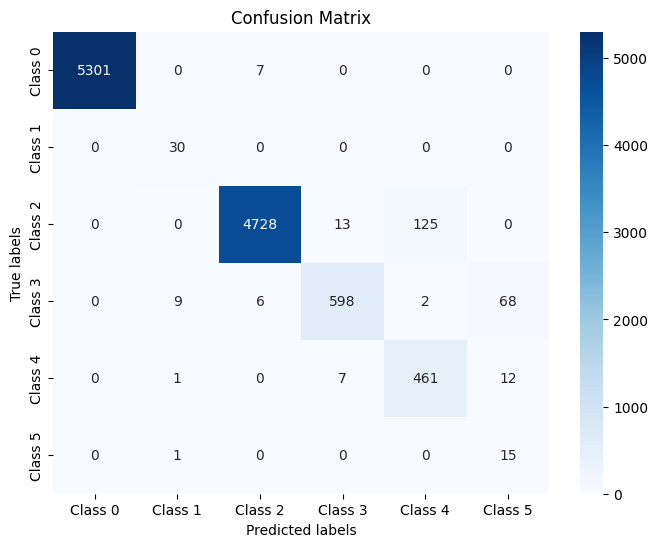

In [12]:
conf_matrix = confusion_matrix(y_pred, y_test)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
labels = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Now let's try resampling and test if we get slighlty better results

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

In [18]:
# applying smote oversampling for the minority class
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(y_train_resampled.value_counts())

AQI Category
0    1369
2    1369
3    1369
5    1369
4    1369
1    1369
Name: count, dtype: int64


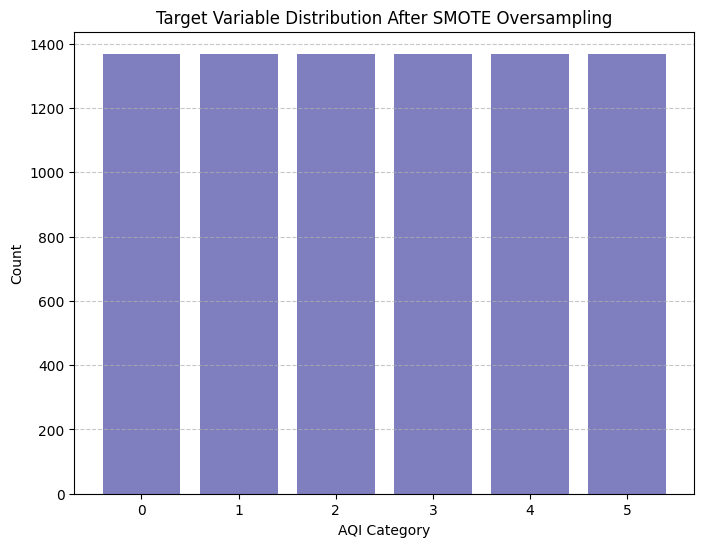

In [24]:
import numpy as np

unique_classes, class_counts = np.unique(y_train_resampled, return_counts=True)

plt.figure(figsize=(8, 6))
plt.bar(unique_classes, class_counts, color="navy", alpha=0.5)
plt.title("Target Variable Distribution After SMOTE Oversampling")
plt.xlabel("AQI Category")
plt.ylabel("Count")
plt.xticks(unique_classes)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [25]:
lgr_.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = lgr_.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5301
           1       1.00      0.78      0.88        41
           2       1.00      0.88      0.94      4741
           3       0.50      0.88      0.64       618
           4       0.90      0.97      0.93       588
           5       0.63      0.97      0.76        95

    accuracy                           0.94     11384
   macro avg       0.84      0.91      0.86     11384
weighted avg       0.96      0.94      0.95     11384



As we can see, the metrics do not imporve with resampling